In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
# check GPU device
print(device_lib.list_local_devices())
tf.__version__
tf.test.is_gpu_available()


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13983749874380235235
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2913966491
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2230645934501557178
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
# 自動選擇空閒 GPU 進行模型訓練
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
    logical_devices = tf.config.list_logical_devices("GPU")

In [3]:
# -*- coding: utf-8 -*-
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Conv1D, Lambda, Add, Multiply, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import random
import pickle
import glob
from tqdm import tqdm
import os

from python_speech_features import mfcc
import scipy.io.wavfile as wav
import librosa
from IPython.display import Audio


In [4]:
import csv
#載入訓練用的label
with open('D:\Python\ML\HW3\ML@NTUT-2021-Autumn-ASR\\train-toneless_update.csv',newline='',errors='ignore') as csvfile:
    rows=csv.reader(csvfile)
    for row in rows:
        a= row[0]
        b= row[1]
        f=open('D:\\Python\\ML\\HW3\\ML@NTUT-2021-Autumn-ASR\\train_txt\\'+a+'.txt','w')
        f.write(b)
        f.close()

In [5]:
def get_wav_files(wav_path):
    wav_files=[]
    for (dirpath, dirnames, filenames) in os.walk(wav_path):
        for filename in filenames:
            if filename.endswith('.wav') or filename.endswith('.MAV'):
                filename_path = os.path.join(dirpath, filename)
                wav_files.append(filename_path)
            
    return wav_files

#將label轉成TEXT
def get_train_texts(wav_files,tran_path):
    tran_texts=[]
    for wav_file in wav_files:
        basename=os.path.basename(wav_file)
        x=os.path.splitext(basename)[0]
        tran_file=os.path.join(tran_path,x+'.txt')
        
        if os.path.exists(tran_file) is False:
            return None

        fd=open(tran_file,'r')
        text=fd.readline()
        tran_texts.append(text.split('\n')[0])
        fd.close()
    return tran_texts

#設定音檔路徑
wav_path='D:\\Python\\ML\\HW3\\ML@NTUT-2021-Autumn-ASR\\train\\'
tran_path='D:\\Python\\ML\\HW3\\ML@NTUT-2021-Autumn-ASR\\train_txt\\'
wav_files=get_wav_files(wav_path)
tran_texts=get_train_texts(wav_files,tran_path)
print(len(wav_files)) #輸出音檔數量

3119


Audio Text: li be e mih kiann lan lan san san long be tsiau tsng


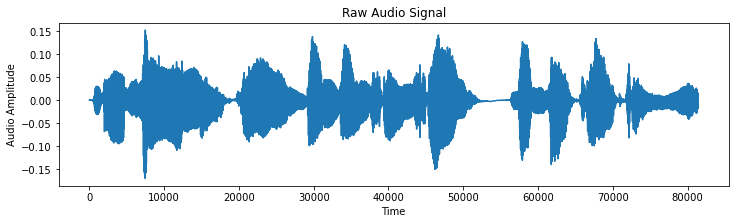

Shape of MFCC: (367, 13)


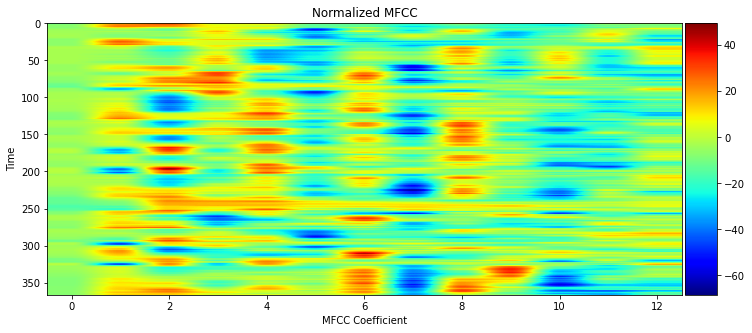

In [6]:
#設定MFCC取樣
mfcc_dim = 13

def load_and_trim(path):
    audio, sr = librosa.load(path) #audio為取樣的訊號值  sr為取樣率
    energy = librosa.feature.rms(audio) #計算每幀的均方根值(RMS)
    frames = np.nonzero(energy >= np.max(energy) / 5)
    indices = librosa.core.frames_to_samples(frames)[1]
    audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
    
    return audio, sr
    


#視覺化取樣後的結果
def visualize(index):
    path = wav_files[index]
    text = tran_texts[index]
    print('Audio Text:', text)
    
    audio, sr = load_and_trim(path)
    plt.figure(figsize=(12, 3))
    plt.plot(np.arange(len(audio)), audio)
    plt.title('Raw Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Audio Amplitude')
    plt.show()
    
    feature = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
    print('Shape of MFCC:', feature.shape)
    
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    im = ax.imshow(feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05))
    ax.set_xticks(np.arange(0, 13, 2), minor=False)
    plt.show()
    
    return path

Audio(visualize(0))

In [7]:
#檢查wav與text 數量一致
print(len(wav_files))
print(len(tran_texts))

3119
3119


In [8]:
#進行特徵抓取
features = []
for i in tqdm(range(len(wav_files))):
    path = wav_files[i]
    audio, sr = load_and_trim(path)
    features.append(mfcc(audio, sr, numcep=mfcc_dim, nfft=551))
    #nfft : FFT大小
    #highfreq : 最高頻帶邊緣，將超出的雜訊移除，可自己新增
    
print(len(features), features[0].shape)

100%|██████████| 3119/3119 [00:47<00:00, 65.39it/s] 

3119 (367, 13)


In [9]:
#標準化 避免出現權重比例失衡 造成難以收斂
samples = random.sample(features, 100)
samples = np.vstack(samples)

mfcc_mean = np.mean(samples, axis=0)
mfcc_std = np.std(samples, axis=0)
print(mfcc_mean)
print(mfcc_std)

features = [(feature - mfcc_mean) / (mfcc_std + 1e-14) for feature in features]

[ -5.81490692  -4.73912236  -5.06266794   0.50028311  -2.67371159
 -14.79335858   3.79186478 -10.86656272  -6.27458744  -5.83097067
 -12.9571025   -9.69485856  -6.86540869]
[ 3.76946555 16.99744321 19.47768479 18.5877528  15.55697336 18.1100004
 14.55248243 15.39213533 15.04558976 13.4630797  13.79818085 12.17815052
 11.84838453]


In [10]:
#將TEXT進行編碼
chars = {}
for text in tran_texts:
    for c in text:
        chars[c] = chars.get(c, 0) + 1

chars = sorted(chars.items(), key=lambda x: x[1], reverse=True)
chars = [char[0] for char in chars]
print(len(chars), chars[:100],"\n")

char2id = {c: i for i, c in enumerate(chars)}
id2char = {i: c for i, c in enumerate(chars)}

print(char2id,"\n",id2char)

53 [' ', 'i', 'a', 'n', 't', 'h', 's', 'u', 'o', 'k', 'g', 'e', 'l', 'p', 'b', 'm', 'j', 'r', 'B', 'C', 'S', 'P', 'd', 'I', 'c', 'R', 'y', 'f', 'A', 'N', 'D', 'T', 'O', 'F', 'V', 'w', 'G', 'M', 'v', 'E', 'J', 'H', 'W', 'Y', 'U', 'x', 'L', 'q', 'X', 'z', 'Z', 'K', 'Q'] 

{' ': 0, 'i': 1, 'a': 2, 'n': 3, 't': 4, 'h': 5, 's': 6, 'u': 7, 'o': 8, 'k': 9, 'g': 10, 'e': 11, 'l': 12, 'p': 13, 'b': 14, 'm': 15, 'j': 16, 'r': 17, 'B': 18, 'C': 19, 'S': 20, 'P': 21, 'd': 22, 'I': 23, 'c': 24, 'R': 25, 'y': 26, 'f': 27, 'A': 28, 'N': 29, 'D': 30, 'T': 31, 'O': 32, 'F': 33, 'V': 34, 'w': 35, 'G': 36, 'M': 37, 'v': 38, 'E': 39, 'J': 40, 'H': 41, 'W': 42, 'Y': 43, 'U': 44, 'x': 45, 'L': 46, 'q': 47, 'X': 48, 'z': 49, 'Z': 50, 'K': 51, 'Q': 52} 
 {0: ' ', 1: 'i', 2: 'a', 3: 'n', 4: 't', 5: 'h', 6: 's', 7: 'u', 8: 'o', 9: 'k', 10: 'g', 11: 'e', 12: 'l', 13: 'p', 14: 'b', 15: 'm', 16: 'j', 17: 'r', 18: 'B', 19: 'C', 20: 'S', 21: 'P', 22: 'd', 23: 'I', 24: 'c', 25: 'R', 26: 'y', 27: 'f', 28: 'A', 29: 'N'

In [11]:
# create training and testing(validation) dataset
# training : validation = 9 : 1


data_index = np.arange(len(wav_files))
np.random.shuffle(data_index)
train_size = int(0.9 * len(wav_files))
test_size = len(wav_files) - train_size
train_index = data_index[:train_size]
test_index = data_index[train_size:]

X_train = [features[i] for i in train_index]
Y_train = [tran_texts[i] for i in train_index]
X_test = [features[i] for i in test_index]
Y_test = [tran_texts[i] for i in test_index]

#設定batch_size大小 太大會造成OOM
batch_size = 2

# 使用generator 進行分批訓練
# 以減少記憶體占用   
def batch_generator(x, y, batch_size=batch_size):  
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            data_index = np.arange(len(x))
            np.random.shuffle(data_index)
            x = [x[i] for i in data_index]
            y = [y[i] for i in data_index]
            offset = batch_size
            
        X_data = x[offset - batch_size: offset]
        Y_data = y[offset - batch_size: offset]
        
        X_maxlen = max([X_data[i].shape[0] for i in range(batch_size)])
        Y_maxlen = max([len(Y_data[i]) for i in range(batch_size)])
        
        X_batch = np.zeros([batch_size, X_maxlen, mfcc_dim])
        Y_batch = np.ones([batch_size, Y_maxlen]) * len(char2id)
        X_length = np.zeros([batch_size, 1], dtype='int32')
        Y_length = np.zeros([batch_size, 1], dtype='int32')
        
        for i in range(batch_size):
            X_length[i, 0] = X_data[i].shape[0]
            X_batch[i, :X_length[i, 0], :] = X_data[i]
            
            Y_length[i, 0] = len(Y_data[i])
            Y_batch[i, :Y_length[i, 0]] = [char2id[c] for c in Y_data[i]]
        
        inputs = {'X': X_batch, 'Y': Y_batch, 'X_length': X_length, 'Y_length': Y_length}
        outputs = {'ctc': np.zeros([batch_size])}
        
        yield (inputs, outputs)

In [12]:
epochs = 50 #訓練批次
num_blocks = 3 #RNN的層數
filters = 256 #輸出空間的維度

X = Input(shape=(None, mfcc_dim,), dtype='float32', name='X')
Y = Input(shape=(None,), dtype='float32', name='Y')
X_length = Input(shape=(1,), dtype='int32', name='X_length')
Y_length = Input(shape=(1,), dtype='int32', name='Y_length')

# kernel_size : 1D卷積窗口長度
# dilation_rate : 膨脹比例
# Strides : 卷積的步長
# causal : 使用膨脹卷積
def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)

def batchnorm(inputs):
    return BatchNormalization()(inputs)

def activation(inputs, activation):
    return Activation(activation)(inputs)

def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'tanh')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])
    
    ha = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    hs = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    
    return Add()([ha, inputs]), hs

h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'tanh')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu')
Y_pred = activation(batchnorm(conv1d(h1, len(char2id) + 1, 1, 1)), 'softmax')
sub_model = Model(inputs=X, outputs=Y_pred)


In [13]:
# 定義CTC loss
def calc_ctc_loss(args):
    y, yp, ypl, yl = args
    return K.ctc_batch_cost(y, yp, ypl, yl)

ctc_loss = Lambda(calc_ctc_loss, output_shape=(1,), name='ctc')([Y, Y_pred, X_length, Y_length])
model = Model(inputs=[X, Y, X_length, Y_length], outputs=ctc_loss)
#使用SGD最為優化器
optimizer = SGD(learning_rate=0.02, momentum=0.9, nesterov=True, clipnorm=5)
model.compile(loss={'ctc': lambda ctc_true, ctc_pred: ctc_pred}, optimizer=optimizer)
#設定checkpoint與lr_decay
checkpointer = ModelCheckpoint(filepath='asr.h5', verbose=0, monitor='val_loss', save_best_only=True, mode='min')
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, None, 13)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 256)    3584        X[0][0]                          
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, 256)    1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, 256)    0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [19]:
#進行model訓練
#並將訓練過程儲存為history
history = model.fit(
    batch_generator(X_train, Y_train), 
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs, 
    validation_data=batch_generator(X_test, Y_test), 
    validation_steps=len(X_test) / batch_size, 
    callbacks=[checkpointer, lr_decay])

Epoch 1/50
1403/1403 [==============================] - 589s 405ms/step - loss: 85.9265 - val_loss: 62.0639


C:\Users\D\anaconda3\envs\ml\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
1403/1403 [==============================] - 456s 325ms/step - loss: 44.1190 - val_loss: 66.2121
Epoch 3/50
1403/1403 [==============================] - 452s 322ms/step - loss: 37.0256 - val_loss: 61.5151
Epoch 4/50
1403/1403 [==============================] - 447s 319ms/step - loss: 32.5070 - val_loss: 59.3321
Epoch 5/50
1403/1403 [==============================] - 452s 322ms/step - loss: 28.8488 - val_loss: 58.9859
Epoch 6/50
1403/1403 [==============================] - 447s 319ms/step - loss: 26.0888 - val_loss: 58.1496
Epoch 7/50
1403/1403 [==============================] - 468s 333ms/step - loss: 23.3850 - val_loss: 54.9981
Epoch 8/50
1403/1403 [==============================] - 487s 347ms/step - loss: 21.1727 - val_loss: 58.5707
Epoch 9/50
1403/1403 [==============================] - 492s 350ms/step - loss: 18.3939 - val_loss: 62.0709
Epoch 10/50
1403/1403 [==============================] - 470s 335ms/step - loss: 16.9341 - val_loss: 68.0844
Epoch 11/50
1403/1403 [====

In [20]:
# 儲存 model、解碼字典與mfcc參數
sub_model.save('asr4.h5')
with open('dictionary.pkl', 'wb') as fw:
    pickle.dump([char2id, id2char, mfcc_mean, mfcc_std], fw)

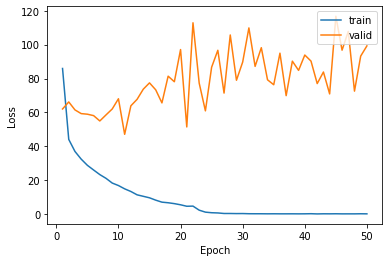

In [21]:
#輸出loss
#使用SGD 可以觀察到valid 會出現較大的震盪
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(np.linspace(1, epochs, epochs), train_loss, label='train')
plt.plot(np.linspace(1, epochs, epochs), valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [23]:
#隨機輸出一組 train和valid的預測結果
def random_predict(x, y):
    index = np.random.randint(len(x))
    feature = x[index]
    text = y[index]

    pred = sub_model.predict(np.expand_dims(feature, axis=0))
    pred_ids = K.eval(K.ctc_decode(pred, [feature.shape[0]], greedy=False, beam_width=10, top_paths=1)[0][0])
    pred_ids = pred_ids.flatten().tolist()
    
    print('True transcription:\n-- ', text, '\n')
    
    # 使用CTC會使input與output長度一致
    # 導致output結尾會輸出許多-1
    # 須將其移除 才能正確進行decoder
    while(-1 in pred_ids): 
        pred_ids.remove(-1)
    print('Predicted transcription:\n-- ' + ''.join([id2char[i] for i in pred_ids]), '\n')

random_predict("Training: \n",X_train, Y_train)
random_predict("Validation: \n",X_test, Y_test)

True transcription:
--  gua ma si kang khuan 

Predicted transcription:
-- gua ma si kang khuan 

True transcription:
--  li e hing hok ti to ui 

Predicted transcription:
-- li e hing hok tit to ui 

